# MNIST handwritten digits

Trying to classify handwritten digits using a neural network in pytorch.

Following the pytorch tutorials at https://pytorch.org/tutorials/beginner/basics/intro.html.

## Getting the data

In [1]:
# Packages and modules
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision

# Functions and classes
from torchvision.transforms import ToTensor, Lambda
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

In [2]:
# Download and/or load dataset (thanks Yann), and transform to tensors, and one-hot encodings
target_transform = Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
train = MNIST(root="data", transform=ToTensor(), target_transform=target_transform, download=True)
test = MNIST(root="data", transform=ToTensor(), target_transform=target_transform, download=True)

In [63]:
# Make dataloader
train_dataloader = DataLoader(train, batch_size=64)
test_dataloader = DataLoader(test, batch_size=64)

In [96]:
# Load iterable
examples = enumerate(train_dataloader)

In [97]:
# Get first sample and check shape
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape

torch.Size([64, 1, 28, 28])

In [50]:
example_targets.shape

torch.Size([64, 10])

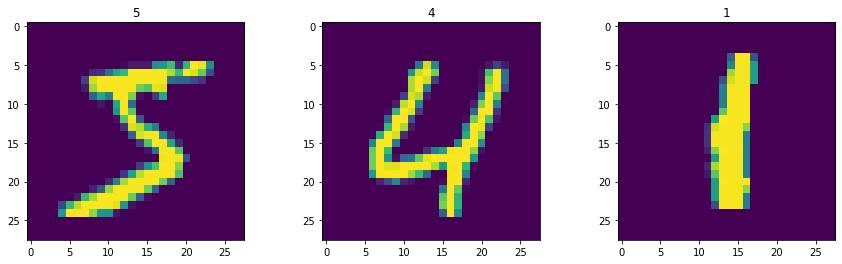

In [51]:
# Show first few sample inputs and labels
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
for i in range(3):
    ax = [ax1, ax2, ax3][i]
    ax.imshow(example_data[0][0])
    ax.set_title(f"{example_targets[0].argmax(0)}")
    batch_idx, (example_data, example_targets) = next(examples)
plt.show()

## Build neural network model

In [52]:
# Breakdown modelling functions
X = torch.rand(1, 28, 28)
print(f"Input: {X.shape}")

X_flat = nn.Flatten()(X)
print(f"Flattened: {X_flat.shape}")

X_l = nn.Linear(28*28, 4)(X_flat)
print(f"Linear: {X_l}")

X_r = nn.ReLU()(X_l)
print(f"ReLU: {X_r}")

logits = nn.Linear(4, 4)(X_r)
print(f"Model: {logits}")

pred_probab = nn.Softmax(dim=1)(logits)
print(f"Probabilities: {pred_probab}")

print(f"Predicted class: {pred_probab.argmax(1)}")

Input: torch.Size([1, 28, 28])
Flattened: torch.Size([1, 784])
Linear: tensor([[-0.2669, -0.3757, -0.1607, -0.2081]], grad_fn=<AddmmBackward0>)
ReLU: tensor([[0., 0., 0., 0.]], grad_fn=<ReluBackward0>)
Model: tensor([[-0.2775,  0.1596,  0.2793,  0.2660]], grad_fn=<AddmmBackward0>)
Probabilities: tensor([[0.1662, 0.2574, 0.2901, 0.2863]], grad_fn=<SoftmaxBackward0>)
Predicted class: tensor([2])


In [53]:
# Create a neural network
seq_modules = nn.Sequential(
    nn.Linear(28*28, 512),
    nn.ReLU(),
    nn.Linear(512, 512),
    nn.ReLU(),
    nn.Linear(512, 10),
)
seq_modules(X_flat)

tensor([[ 0.0204, -0.0068, -0.0713,  0.0412,  0.0300,  0.0322,  0.0252,  0.1271,
          0.0448, -0.0678]], grad_fn=<AddmmBackward0>)

In [54]:
# Create neural network model class
class NeuralNetwork(nn.Module):
    def __init__(self, seq_modules):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = seq_modules

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [55]:
# Create neural network model
model = NeuralNetwork(seq_modules)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [56]:
name, param = next(model.named_parameters())
print(f"Layer: {name}")
print(f"Size: {param.size()}")
print(f"Values : {param[:2]} \n")

Layer: linear_relu_stack.0.weight
Size: torch.Size([512, 784])
Values : tensor([[ 0.0078,  0.0243, -0.0324,  ...,  0.0215, -0.0233,  0.0139],
        [-0.0357, -0.0288,  0.0010,  ...,  0.0122, -0.0199, -0.0126]],
       grad_fn=<SliceBackward0>) 



In [57]:
# Use model to get predictions
model(X)

tensor([[ 0.0204, -0.0068, -0.0713,  0.0412,  0.0300,  0.0322,  0.0252,  0.1271,
          0.0448, -0.0678]], grad_fn=<AddmmBackward0>)

In [65]:
# Set device to GPU or CPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [66]:
# Create neural network model
model = model.to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [67]:
# Use model to get predictions on GPU
X = torch.rand(1, 28, 28, device=device)
logits = model(X)
print(f"Model: {logits}")

Model: tensor([[ 0.1272, -0.0779,  0.0465,  0.0137,  0.0006,  0.0166,  0.0495,  0.0996,
          0.0602, -0.0617]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [81]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X.to(device))
        loss = loss_fn(pred, y.to(device))

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            y = y.to(device)
            pred = model(X.to(device))
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [82]:
learning_rate = 1e-3
batch_size = 64
epochs = 1

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [106]:
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.583600  [    0/60000]
loss: 0.462439  [ 6400/60000]
loss: 0.505150  [12800/60000]
loss: 0.534429  [19200/60000]
loss: 0.466478  [25600/60000]
loss: 0.496948  [32000/60000]
loss: 0.399427  [38400/60000]
loss: 0.584895  [44800/60000]
loss: 0.542944  [51200/60000]
loss: 0.559387  [57600/60000]
Test Error: 
 Accuracy: 86.9%, Avg loss: 0.495877 

Done!


In [105]:
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.622746  [    0/60000]
loss: 0.499021  [ 6400/60000]
loss: 0.544829  [12800/60000]
loss: 0.561091  [19200/60000]
loss: 0.502738  [25600/60000]
loss: 0.521273  [32000/60000]
loss: 0.433582  [38400/60000]
loss: 0.613755  [44800/60000]
loss: 0.574180  [51200/60000]
loss: 0.580128  [57600/60000]
Test Error: 
 Accuracy: 86.4%, Avg loss: 0.524089 

Done!


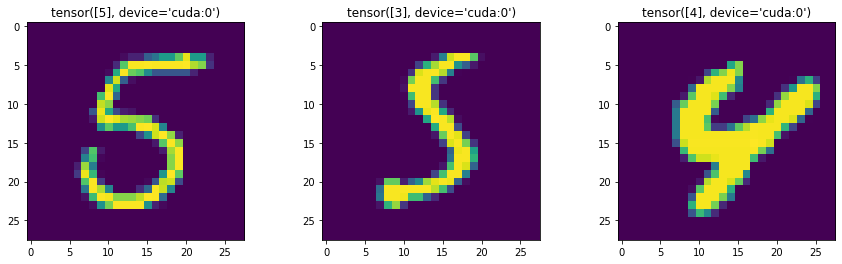

In [103]:
# Show first few sample inputs and labels
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
for i in range(3):
    ax = [ax1, ax2, ax3][i]
    ax.imshow(example_data[0][0])
    ax.set_title(f"{model(example_data[0].to(device)).argmax(1)}")
    batch_idx, (example_data, example_targets) = next(examples)
plt.show()

In [99]:
model(example_data[0].to(device))

tensor([[ 7.1682, -7.1206,  1.4448, -0.7304, -0.8856,  3.3776,  3.7621, -3.5873,
          0.3273, -1.9473]], device='cuda:0', grad_fn=<AddmmBackward0>)